In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")
from pinns import *
from local_utils import *

from pinns import *
from intro import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dev_str = f"{device.type}:{device.index}"

In [3]:
import pickle
with open(f"./inputs/solution_3.pkl", "rb") as f:
    (run_params, params, solution) = pickle.load(f)
    
    
run_params = Struct(**run_params)
params = Struct(**params)

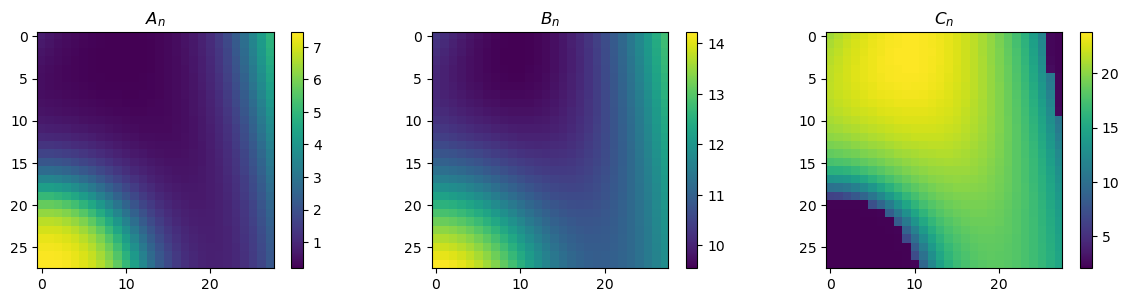

In [57]:
A_n = solution[-1, 0, :, :]
B_n = solution[-1, 1, :, :]
C_n = solution[-1, 2, :, :]

#############################################################
#    Inner boundaries
# By using these slices, we can remove the boundary effects
# or select a smaller portion of the domain
#
#   Important: slices must not be larger than slices(1,-1,1).
#              Otherwise, the boundary effects of finit difference
#              Laplacian cannot be removed
#
x_slice = slice(50,-50, 1)
y_slice = slice(50,-50, 1)

to = create_to(A_n[x_slice,y_slice])
############################################################
plot_n_im([A_n[x_slice,y_slice], 
           B_n[x_slice,y_slice], 
           C_n[x_slice,y_slice]], 
          [r"$A_{n}$", r"$B_{n}$", r"$C_{n}$"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

Epoch: 1 
 data loss:5.166360, 
data A loss:1.615827, data B loss:0.821646, data C loss:2.728888, 
Laplacian A loss:11.851137, Laplacian B loss:4.812641
Negative loss:0.659441




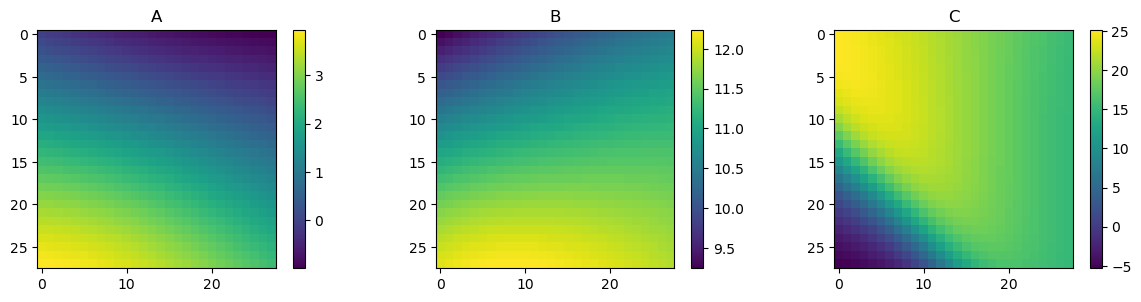

Epoch: 100 
 data loss:0.005283, 
data A loss:0.002462, data B loss:0.000821, data C loss:0.002000, 
Laplacian A loss:0.010903, Laplacian B loss:0.008846
Negative loss:0.000000




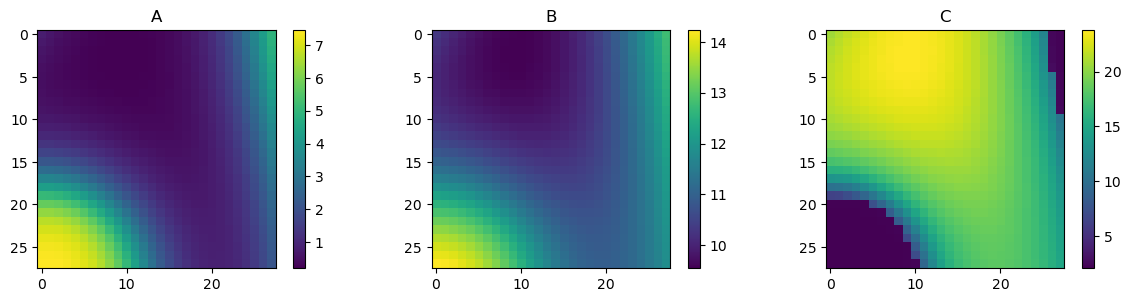

Epoch: 200 
 data loss:0.004560, 
data A loss:0.002333, data B loss:0.000787, data C loss:0.001441, 
Laplacian A loss:0.008763, Laplacian B loss:0.006683
Negative loss:0.000000




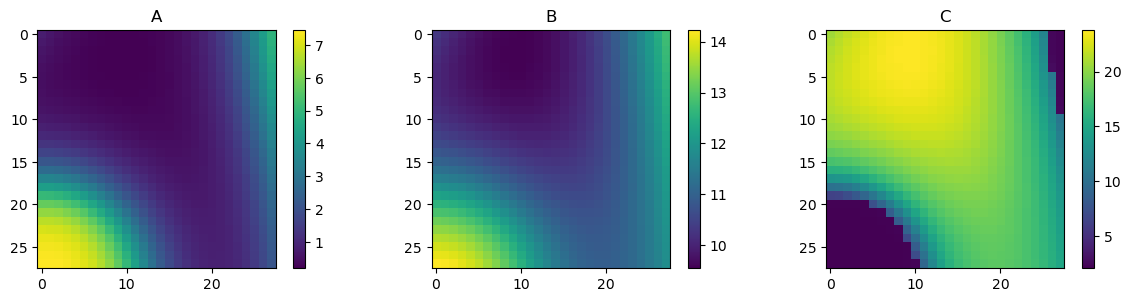

Epoch: 300 
 data loss:0.004560, 
data A loss:0.002333, data B loss:0.000787, data C loss:0.001441, 
Laplacian A loss:0.008763, Laplacian B loss:0.006683
Negative loss:0.000000




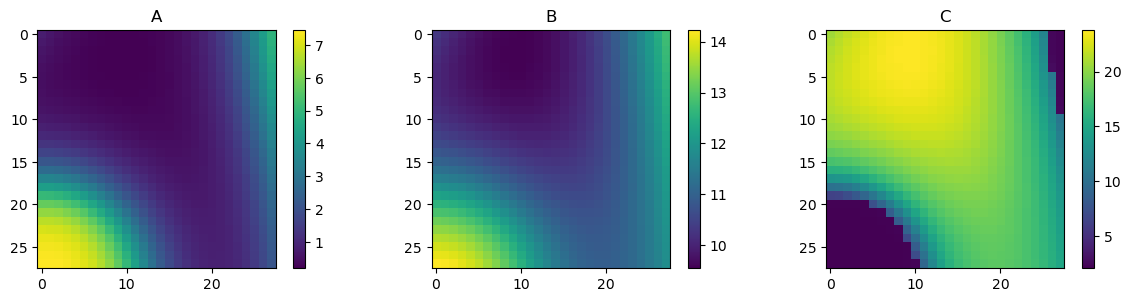

Epoch: 400 
 data loss:0.004560, 
data A loss:0.002333, data B loss:0.000787, data C loss:0.001441, 
Laplacian A loss:0.008763, Laplacian B loss:0.006683
Negative loss:0.000000




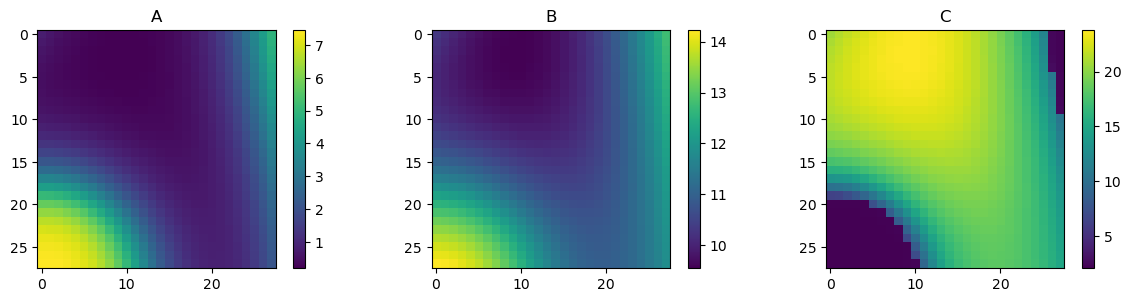

Epoch: 500 
 data loss:0.004560, 
data A loss:0.002333, data B loss:0.000787, data C loss:0.001441, 
Laplacian A loss:0.008763, Laplacian B loss:0.006683
Negative loss:0.000000




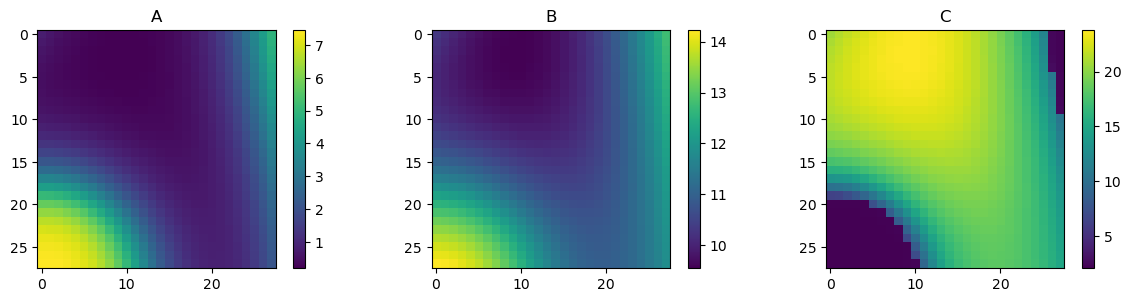

In [124]:
torch.manual_seed(42)
np.random.seed(42)
dtype = torch.float32
torch.set_default_dtype(dtype)

###########################################################
# Inputs
# restrict to inner boundaries
x = torch.linspace(0, run_params.Lx, run_params.Ix)[x_slice].to(device)
y = torch.linspace(0, run_params.Ly, run_params.Jy)[y_slice].to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
data_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)
##########################################################
#   Data
# restrict to inner boundaries
data_A = torch.from_numpy(A_n[x_slice,y_slice].flatten()).to(device)
data_B = torch.from_numpy(B_n[x_slice,y_slice].flatten()).to(device)
data_C = torch.from_numpy(C_n[x_slice,y_slice].flatten()).to(device)
###########################################################
# Laplacians
# First, find the finite-diff Laplacian on the whole domain,
# then, select the inner boundaries. This way, the boundaries 
# effets removed
diffusion_scale_factor = (run_params.Ix-1)*(run_params.Jy-1)/(run_params.Lx*run_params.Ly)
laplacianA = diffusion_scale_factor * grad_diff(A_n)
laplacianB = diffusion_scale_factor * grad_diff(B_n)

laplacianA = torch.tensor(laplacianA[x_slice,y_slice].flatten()).to(device)
laplacianB = torch.tensor(laplacianB[x_slice,y_slice].flatten()).to(device)
###########################################################
zeors_tensor = torch.zeros(data_X.shape[0]).to(device)
###########################################################
# Model
lb = torch.tensor([torch.min(x).item(), torch.min(y).item()]).to(device)
ub = torch.tensor([torch.max(x).item(), torch.max(y).item()]).to(device)
model = Net_sep_dense_normalised(2,3,[800,800,800,800], lb, ub).to(device)
###########################################################
# optimizer
optimizer = torch.optim.LBFGS([*model.parameters()], lr=1
                             ,line_search_fn='strong_wolfe')#.Adam([*model.parameters()], lr=1e-4)#


epochs = 500
loss_data = 0.0
lambda_data = 1.0
loss_physics = 0.0
lambda_physics_laplacian = 1e-2
loss_negative = 0
lambda_negative = 100

losses = np.zeros((6, epochs))

def act(x, km, n=2):
    return x**n / (x**n + km**n)

def inh(x, km, n=2):
    return  km**n / (x**n + km**n)

# last_loss = np.inf
# early_stop = False
for i in range(epochs ):
    flg_new_call = True
    # L-BFGS
    def closure():
        
        optimizer.zero_grad()

        #################################
        # data loss
        data_f_hat = model(data_X)
        data_A_hat = data_f_hat[0].squeeze() 
        data_B_hat = data_f_hat[1].squeeze() 
        data_C_hat = data_f_hat[2].squeeze() 
        loss_A_data = torch.mean((data_A - data_A_hat)**2)
        loss_B_data = torch.mean((data_B - data_B_hat)**2)
        loss_C_data = torch.mean((data_C - data_C_hat)**2)
        loss_data = (loss_A_data + loss_B_data + loss_C_data)/3
        #################################
        loss_negative = torch.mean(torch.maximum(-data_A_hat, zeors_tensor)**2
                       )+ torch.mean(torch.maximum(-data_B_hat, zeors_tensor)**2
                       )+ torch.mean(torch.maximum(-data_C_hat, zeors_tensor)**2
                       )
        #################################
        # physics derivatives
        A = data_A_hat
        B = data_B_hat
        C = data_C_hat

        laplacianA_hat = Laplacian(A, data_X)
        laplacianB_hat = Laplacian(B, data_X)
        
        A_loss_laplacian = torch.mean((laplacianA_hat-laplacianA)**2)
        B_loss_laplacian = torch.mean((laplacianB_hat-laplacianB)**2)
        loss_laplacian_physics = A_loss_laplacian + B_loss_laplacian
        ###############################
        total_loss = (
            +lambda_data*loss_data            
            +lambda_physics_laplacian*loss_laplacian_physics
            #+lambda_negative*loss_negative
                        )

        total_loss.backward(retain_graph=True)
        
        
        losses[:,i] = (loss_A_data.item(), loss_B_data.item(), loss_C_data.item(), 
                       A_loss_laplacian.item(), B_loss_laplacian.item(),
                       loss_negative.item())                    
            
        return total_loss
    
    
    
    optimizer.step(closure)
#     if i < epochs and last_loss > np.sum(losses[:,i]):
#         last_loss =  np.sum(losses[:,i])
#         if i > 200:
#             torch.save(model.state_dict(), "./04_outputs/model_LBFGS_Field_only_non_stationary_31")
            
#     elif np.sum(losses[:,i]) < last_loss:
#         ls = np.sqrt(losses[:, i])
#         print("============================================")
#         print(f"Stoped at {i+1}")
#         print("============================================")
#         print(f"Epoch: {i+1} \n data loss:{np.sum(ls[0:3]):.6f}, \n"
#               f"data A loss:{ls[0]:.6f}, data B loss:{ls[1]:.6f}, data C loss:{ls[2]:.6f}, \n"
#               f"Laplacian A loss:{ls[3]:.6f}, Laplacian B loss:{ls[4]:.6f}\n"
#               f"Negative loss:{ls[5]:.6f}\n"
#               f"\n"
#              )
#         data_f_hat = model(data_X)        
#         data_A_hat = data_f_hat[0].squeeze() 
#         data_B_hat = data_f_hat[1].squeeze() 
#         data_C_hat = data_f_hat[2].squeeze() 
#         plot_n_im([to(data_A_hat.cpu().detach().numpy()), 
#                    to(data_B_hat.cpu().detach().numpy()), 
#                    to(data_C_hat.cpu().detach().numpy())], 
#            ["A","B","C"],          
#         figsize=(12, 3)); plt.tight_layout();plt.show() 
#         early_stop = True
#         break
    
    if (i+1)%100 == 0 or i==0 :
        ls = np.sqrt(losses[:, i])
        print("============================================")
        print(f"Epoch: {i+1} \n data loss:{np.sum(ls[0:3]):.6f}, \n"
              f"data A loss:{ls[0]:.6f}, data B loss:{ls[1]:.6f}, data C loss:{ls[2]:.6f}, \n"
              f"Laplacian A loss:{ls[3]:.6f}, Laplacian B loss:{ls[4]:.6f}\n"
              f"Negative loss:{ls[5]:.6f}\n"
              f"\n"
             )
        data_f_hat = model(data_X)        
        data_A_hat = data_f_hat[0].squeeze() 
        data_B_hat = data_f_hat[1].squeeze() 
        data_C_hat = data_f_hat[2].squeeze() 
        plot_n_im([to(data_A_hat.cpu().detach().numpy()), 
                   to(data_B_hat.cpu().detach().numpy()), 
                   to(data_C_hat.cpu().detach().numpy())], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 
        
# if not early_stop:
#     model = Net_sep_dense_normalised(2,3,[ 512, 512, 512], lb, ub)
#     model.load_state_dict(torch.load("./04_outputs/model_LBFGS_Field_only_non_stationary_31"))
#     model.to(device)

# Plot the trained outputs

A RMSE:0.0023327686275311523 B RMSE:0.0007870180471362216 C RMSE:0.0014405445847228764
F_A actual:0.014304878081471248, F_A:0.014284372329711914, RMSE: 0.00027910939294982024
F_B actual:21.293602030550574, F_B:21.280067443847656, RMSE: 0.005943455383035426
F_C actual:6.361155673627203e-13, F_C:4.257917225913843e-06, RMSE: 0.0020635257283557963

Laplacian A RMSE: 0.008763092180032964
Laplacian B RMSE: 0.006683433127054237

dAdt RMSE: 0.0002891261408561307
dBdt RMSE: 0.00883609360856846
dCdt RMSE: 0.0020635257283557963


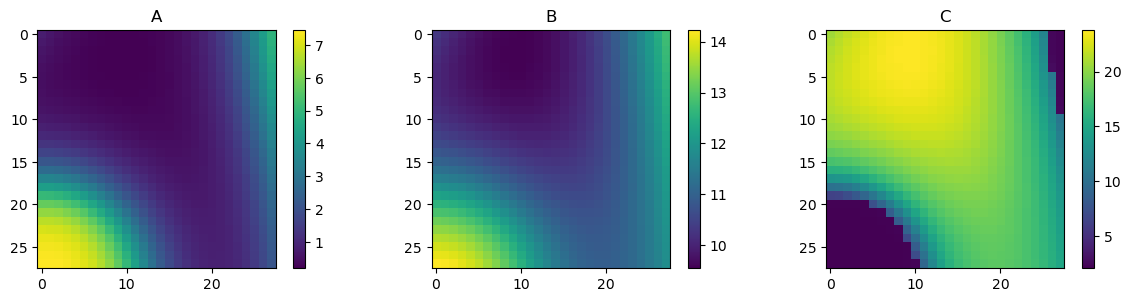

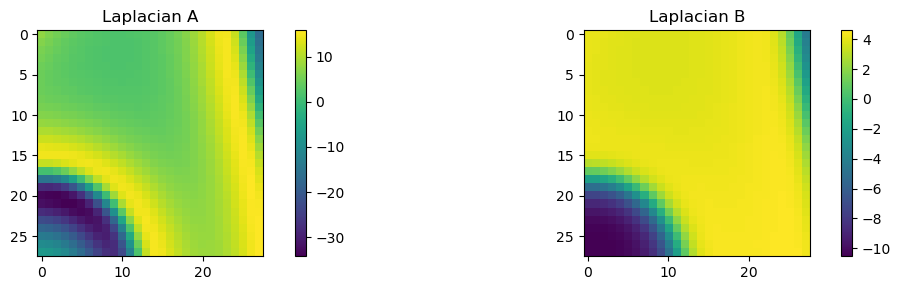

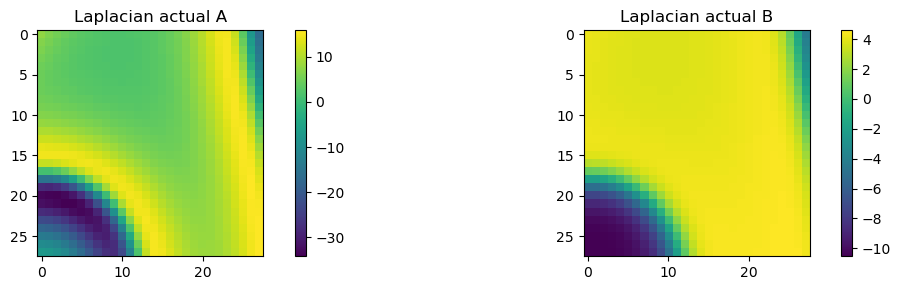

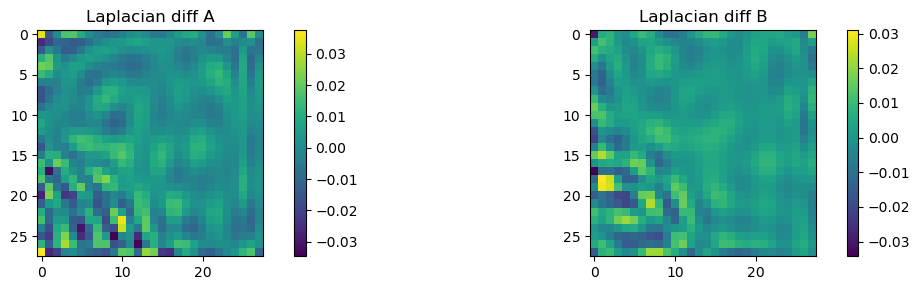

In [125]:
physics_f = model(data_X)
A_hat = physics_f[0].squeeze()
B_hat = physics_f[1].squeeze()
C_hat = physics_f[2].squeeze()

laplacianA_hat = Laplacian(A_hat, data_X)
laplacianB_hat = Laplacian(B_hat, data_X)

A_hat = to(A_hat.cpu().detach().numpy())
B_hat = to(B_hat.cpu().detach().numpy())
C_hat = to(C_hat.cpu().detach().numpy())
laplacianA_hat = to(laplacianA_hat.cpu().detach().numpy())
laplacianB_hat = to(laplacianB_hat.cpu().detach().numpy())


laplacianA = diffusion_scale_factor * grad_diff(A_n)[x_slice,y_slice]
laplacianB = diffusion_scale_factor * grad_diff(B_n)[x_slice,y_slice]

n = params["n"]

A = A_n[x_slice,y_slice]
B = B_n[x_slice,y_slice]
C = C_n[x_slice,y_slice]

F_A =  params["b_A"] + params["V_A"]*act(A, params["K_AA"], n)*inh(B, params["K_BA"], n) - params["mu_A"] * A
F_A_hat =  params["b_A"] + params["V_A"]*act(A_hat, params["K_AA"], n)*inh(B_hat, params["K_BA"], n) - params["mu_A"] * A_hat
F_B =  params["b_B"] + params["V_B"]*act(A, params["K_AB"], n)*inh(C, params["K_CB"], n) - params["mu_B"] * B
F_B_hat =  params["b_B"] + params["V_B"]*act(A_hat, params["K_AB"], n)*inh(C_hat, params["K_CB"], n) - params["mu_B"] * B_hat
F_C =  params["b_C"] + params["V_C"]*inh(A, params["K_AC"], n)*inh(B, params["K_BC"], n)*act(C, params["K_CC"], n) - params["mu_C"] * C
F_C_hat =  params["b_C"] + params["V_C"]*inh(A_hat, params["K_AC"], n)*inh(B_hat, params["K_BC"], n)*act(C_hat, params["K_CC"], n) - params["mu_C"] * C_hat


dAdt = params["D_A"]*laplacianA + F_A
dAdt_hat = params["D_A"]*laplacianA_hat + F_A_hat
dBdt = params["D_B"]*laplacianB + F_B
dBdt_hat = params["D_B"]*laplacianB_hat + F_B_hat

print(f"A RMSE:{np.sqrt(np.mean((A_hat-A)**2))}",
      f"B RMSE:{np.sqrt(np.mean((B_hat-B)**2))}",
      f"C RMSE:{np.sqrt(np.mean((C_hat-C)**2))}")

print(f"F_A actual:{np.mean(F_A**2)}, F_A:{np.mean(F_A_hat**2)}, RMSE: {np.sqrt(np.mean((F_A - F_A_hat)**2))}")
print(f"F_B actual:{np.mean(F_B**2)}, F_B:{np.mean(F_B_hat**2)}, RMSE: {np.sqrt(np.mean((F_B - F_B_hat)**2))}")
print(f"F_C actual:{np.mean(F_C**2)}, F_C:{np.mean(F_C_hat**2)}, RMSE: {np.sqrt(np.mean((F_C - F_C_hat)**2))}")
      

print()
print(f"Laplacian A RMSE: {np.sqrt(np.mean((laplacianA_hat-laplacianA)**2))}")
print(f"Laplacian B RMSE: {np.sqrt(np.mean((laplacianB_hat-laplacianB)**2))}")

print()
print(f"dAdt RMSE: {np.sqrt(np.mean((dAdt-dAdt_hat)**2))}")
print(f"dBdt RMSE: {np.sqrt(np.mean((dBdt-dBdt_hat)**2))}")
print(f"dCdt RMSE: {np.sqrt(np.mean((F_C-F_C_hat)**2))}")

plot_n_im([A_hat, B_hat, C_hat], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()


plot_n_im([laplacianA_hat, laplacianB_hat], 
          ["Laplacian A", "Laplacian B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA, laplacianB], 
          ["Laplacian actual A", "Laplacian actual B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA_hat-laplacianA, laplacianB_hat-laplacianB], 
          ["Laplacian diff A", "Laplacian diff B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()



# Plot losses

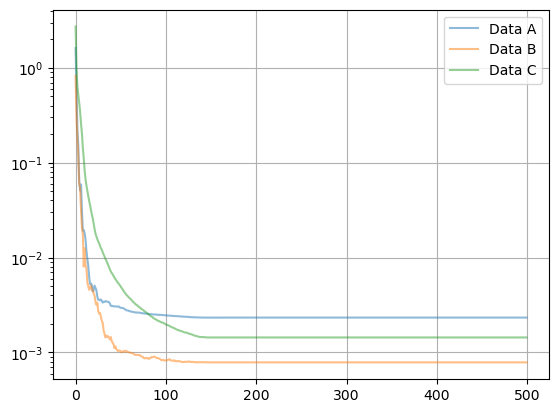

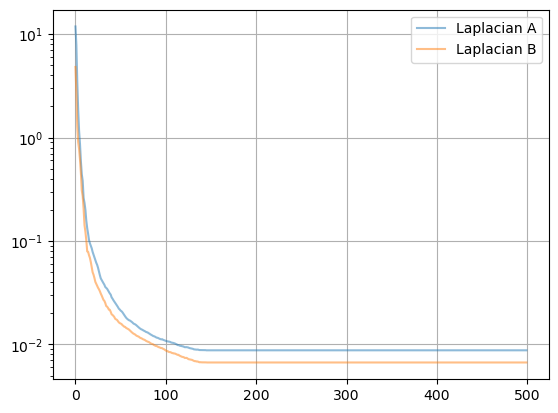

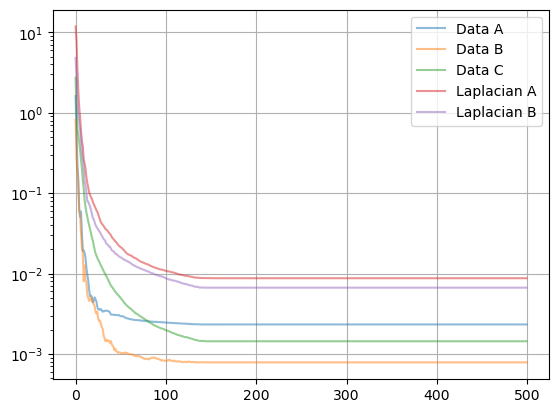

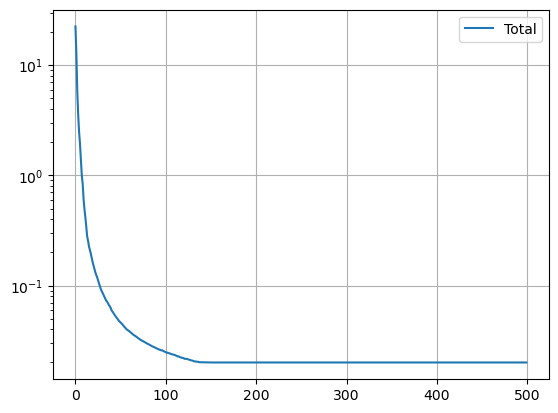

In [126]:
ls= np.sqrt(losses)
plt.plot(ls[0,:], alpha=.5, label="Data A")
plt.plot(ls[1,:], alpha=.5, label="Data B")
plt.plot(ls[2,:], alpha=.5, label="Data C")
plt.yscale('log');plt.grid();plt.legend();plt.show()

plt.plot(ls[3,:], alpha=.5, label="Laplacian A")
plt.plot(ls[4,:], alpha=.5, label="Laplacian B")
plt.yscale('log');plt.grid();plt.legend();plt.show()


plt.plot(ls[0,:], alpha=.5, label="Data A")
plt.plot(ls[1,:], alpha=.5, label="Data B")
plt.plot(ls[2,:], alpha=.5, label="Data C")
plt.plot(ls[3,:], alpha=.5, label="Laplacian A")
plt.plot(ls[4,:], alpha=.5, label="Laplacian B")
plt.yscale('log'); plt.grid();plt.legend();plt.show()

plt.plot(np.sum(ls, axis=0), label="Total")
plt.yscale('log'); plt.grid();plt.legend();plt.show()


# Plot the trained Field and its difference

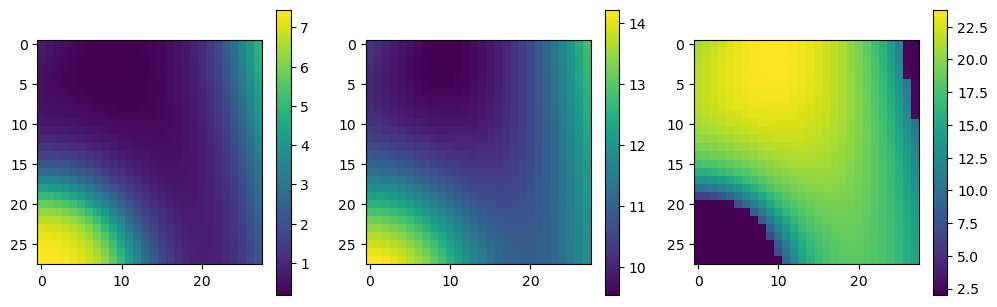

In [127]:
solution_hat = model(data_X)
A_hat = to(solution_hat[0].cpu().detach().numpy())
B_hat = to(solution_hat[1].cpu().detach().numpy())
C_hat = to(solution_hat[2].cpu().detach().numpy())
_ = plt.figure(figsize=(10,6))
plt.subplot(131)
plt.imshow(A_hat)
plt.colorbar(shrink=.5)
plt.subplot(132)
plt.imshow(B_hat)
plt.colorbar(shrink=.5)
plt.subplot(133)
plt.imshow(C_hat)
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

0.0023327686275311523
0.0007870180471362216
0.0014405445847228764


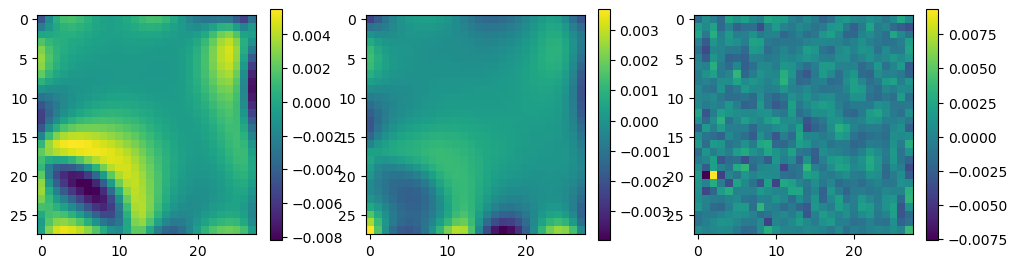

In [128]:
_ = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(A_hat-A)
print(np.sqrt(np.mean((A_hat-A)**2)))
plt.colorbar(shrink=.75)
plt.subplot(132)
plt.imshow(B_hat-B)
print(np.sqrt(np.mean((B_hat-B)**2)))
plt.colorbar(shrink=.75)
plt.subplot(133)
plt.imshow(C_hat-C)
print(np.sqrt(np.mean((C_hat-C)**2)))
plt.colorbar(shrink=.75)
plt.show()


# Second optimisation
## Find the parameters

In [153]:
physics_f = model(data_X)
A_hat = physics_f[0].squeeze()
B_hat = physics_f[1].squeeze()
C_hat = physics_f[2].squeeze()

laplacianA_hat = to(Laplacian(A_hat, data_X).cpu().detach().numpy().astype(np.float64))
laplacianB_hat = to(Laplacian(B_hat, data_X).cpu().detach().numpy().astype(np.float64))

A_hat = to(A_hat.cpu().detach().numpy().astype(np.float64))
B_hat = to(B_hat.cpu().detach().numpy().astype(np.float64))
C_hat = to(C_hat.cpu().detach().numpy().astype(np.float64))

# A_hat = A_n[1:-1, 1:-1]#[x_slice, y_slice]
# B_hat = B_n[1:-1, 1:-1]#[x_slice, y_slice]
# C_hat = C_n[1:-1, 1:-1]#[x_slice, y_slice]

diffusion_scale_factor = (run_params.Ix-1)*(run_params.Jy-1)/(run_params.Lx*run_params.Ly)
laplacianA = diffusion_scale_factor * grad_diff(A_n)
laplacianB = diffusion_scale_factor * grad_diff(B_n)

laplacianA_hat = laplacianA[x_slice, y_slice]
laplacianB_hat = laplacianB[x_slice, y_slice]
    
D_A=params["D_A"]
D_B=params["D_B"]
n = params['n']
mu_C=params["D_A"]

A_min, A_max = np.min(A_hat), np.max(A_hat)
B_min, B_max = np.min(B_hat), np.max(B_hat)
C_min, C_max = np.min(C_hat), np.max(C_hat)
tol = .01

def define_bound(tol, n, x_min, x_max):
    upper = ((1-tol)/tol)**(1/n)
    lower = (tol/(1-tol))**(1/n)
    # return (lower, upper) bounds and the initial guess
    return (max(0,x_min*lower), x_max*upper), max(0, (x_max*upper-max(0,x_min*lower))/2)
    
K_AA_bound, K_AA_init =  define_bound(tol, n, A_min, A_max)
K_AB_bound, K_AB_init =  define_bound(tol, n, A_min, A_max)
K_AC_bound, K_AC_init =  define_bound(tol, n, A_min, A_max)
K_BA_bound, K_BA_init =  define_bound(tol, n, B_min, B_max)
K_BC_bound, K_BC_init =  define_bound(tol, n, B_min, B_max)
K_CB_bound, K_CB_init =  define_bound(tol, n, C_min, C_max)
K_CC_bound, K_CC_init =  define_bound(tol, n, C_min, C_max)


b_A =1#0005#params["b_A"]# 0
b_B =1# 0.5#params["b_B"]#0
b_C =1# 0.5#params["b_C"]#0
V_A =1# 4#params["V_A"]#0
V_B =1# 19#params["V_B"]#0
V_C =1# 19#params["V_C"]#0
mu_A =1# 0.05#params["mu_A"]#
mu_B =1# .4#params["mu_B"]#

K_AA = K_AA_init#params["K_AA"]#K_AA_init
K_AB = K_AB_init#params["K_AB"]#K_AB_init
K_AC = K_AC_init#params["K_AC"]#K_AC_init
K_BA = K_BA_init#params["K_BA"]#K_BA_init
K_BC = K_BC_init#params["K_BC"]#K_BC_init
K_CB = K_CB_init#params["K_CB"]#K_CB_init
K_CC = K_CC_init


params_name_list = [#"D_A", "D_B", 
                    "b_A", "b_B", "b_C", "V_A", "V_B", "V_C", "mu_A", "mu_B", #"mu_C",
                    "K_AA", "K_AB", "K_AC", "K_BA", "K_BC", "K_CB", 
                    "K_CC"
]

params_list = [#D_A, D_B, 
               b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, #mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, 
               K_CC
]

def physics_loss(args):            
    (b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, #mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, 
               K_CC) = args
 

    F_A_hat =  b_A + V_A*act(A_hat, K_AA, n)*inh(B_hat, K_BA, n) - mu_A * A_hat
    #f_A =  e(b_A)/(e(D_A)+1e-6) + e(V_A)*act(A, e(K_AA), n)*inh(B, e(K_BA), n)/(e(D_A)+1e-6) - e(mu_A)*A/(e(D_A)+1e-6)
    F_B_hat =  b_B + V_B*act(A_hat, K_AB, n)*inh(C_hat, K_CB, n) - mu_B * B_hat
    #f_B =  e(b_B)/(e(D_B)+1e-6) + e(V_B)*act(A, e(K_AB), n)*inh(C, e(K_CB), n)/(e(D_B)+1e-6) - e(mu_B)*B/(e(D_B)+1e-6)
    F_C_hat =  b_C + V_C*inh(A_hat, K_AC, n)*inh(B_hat, K_BC, n)*act(C_hat, K_CC, n) - mu_C * C_hat

    
    #dAdt = e(D_A) * laplacianA + F_A
    dAdt = D_A * laplacianA_hat + F_A_hat
    #dAdt2 = laplacianA + f_A
    #dBdt = e(D_B) * laplacianB + F_B
    dBdt = D_B * laplacianB_hat + F_B_hat
    #dBdt2 = laplacianB + f_B
    dCdt = F_C_hat
    ################################
    # physics loss
    # Construct the physics loss here
    A_loss_physics = np.mean(dAdt**2)
    #A2_loss_physics = torch.mean(dAdt2**2)
    B_loss_physics = np.mean(dBdt**2)
    #B2_loss_physics = torch.mean(dBdt2**2)
    C_loss_physics = np.mean(dCdt**2)
    
    return (A_loss_physics + B_loss_physics + C_loss_physics)
i = 0
def print_callback(x):
    global i
    
    if (i+1)%100 == 0 or i == 0:
        print(f"iteration:{i+1}, loss: {physics_loss(x):.8f} ", 
          f", ".join([f"{name}={l:.4f}" 
                 for l, name in zip(x, params_name_list)]))
    i += 1
from scipy.optimize import minimize

bounds = [(0, None),(0, None),(0, None), # b_A, b_B, b_C
          (0, None),(0, None),(0, None), # V_A, V_B, V_C
          (0, None),(0, None), # mu_A, mu_B
          K_AA_bound, K_AB_bound, K_AC_bound,
          K_BA_bound, K_BC_bound,
          K_CB_bound,
          K_CC_bound,
         ]

res = minimize(physics_loss, params_list, bounds=bounds,
               tol=1e-16,
               options={'maxiter':2e4, 'maxfun':1e6},
               method="L-BFGS-B",#"L-BFGS-B",#"Nelder-Mead",# 
               callback=print_callback)
print("==============================================")
i=0
bounds = [(0, None) for _ in params_list]
res_unbound = minimize(physics_loss, params_list, bounds=bounds,
               tol=1e-16,
               options={'maxiter':2e4, 'maxfun':1e6},
               method="L-BFGS-B",#"L-BFGS-B",#"Nelder-Mead",# 
               callback=print_callback)

# print(", ".join([f"{name}={l:.4f}" 
#                  for l, name in zip(res.x, params_name_list)]))


iteration:1, loss: 58.89792312  b_A=1.0974, b_B=1.9882, b_C=0.9337, V_A=1.0059, V_B=1.0254, V_C=0.9928, mu_A=0.9337, mu_B=0.9337, K_AA=11.7238, K_AB=11.7178, K_AC=11.7257, K_BA=20.9275, K_BC=20.9273, K_CB=37.2275, K_CC=37.2282
iteration:100, loss: 0.00313534  b_A=0.0000, b_B=1.4166, b_C=0.1078, V_A=1.0708, V_B=19.9080, V_C=1.2230, mu_A=0.0717, mu_B=0.5388, K_AA=4.5295, K_AB=4.9546, K_AC=11.7347, K_BA=19.7547, K_BC=20.8789, K_CB=37.5297, K_CC=39.4363
iteration:200, loss: 0.00126170  b_A=0.0116, b_B=0.9344, b_C=0.0929, V_A=1.4227, V_B=19.9097, V_C=1.5785, mu_A=0.1147, mu_B=0.4934, K_AA=4.3194, K_AB=4.9838, K_AC=11.7348, K_BA=19.7456, K_BC=20.8870, K_CB=37.5470, K_CC=39.3992
iteration:300, loss: 0.00121423  b_A=0.0104, b_B=0.9566, b_C=0.0968, V_A=1.5234, V_B=19.9087, V_C=1.3987, mu_A=0.1153, mu_B=0.4956, K_AA=4.2979, K_AB=4.9819, K_AC=11.7493, K_BA=17.9897, K_BC=21.3021, K_CB=38.3871, K_CC=38.7139
iteration:400, loss: 0.00098489  b_A=0.0076, b_B=0.9853, b_C=0.0900, V_A=2.3657, V_B=19.9464

iteration:3700, loss: 0.00002878  b_A=0.0000, b_B=0.9974, b_C=0.0230, V_A=9.6365, V_B=19.9728, V_C=0.3744, mu_A=0.0980, mu_B=0.4997, K_AA=5.1659, K_AB=4.9921, K_AC=23.5131, K_BA=8.2353, K_BC=10.4507, K_CB=49.9225, K_CC=9.4526
iteration:3800, loss: 0.00002837  b_A=0.0000, b_B=0.9959, b_C=0.0234, V_A=9.1724, V_B=19.9704, V_C=0.3712, mu_A=0.0982, mu_B=0.4996, K_AA=5.1469, K_AB=4.9918, K_AC=23.5130, K_BA=8.3454, K_BC=10.5031, K_CB=49.5315, K_CC=9.5956
iteration:3900, loss: 0.00002817  b_A=0.0000, b_B=0.9966, b_C=0.0231, V_A=8.9794, V_B=19.9697, V_C=0.3764, mu_A=0.0983, mu_B=0.4996, K_AA=5.1453, K_AB=4.9916, K_AC=23.5130, K_BA=8.4004, K_BC=10.4362, K_CB=49.4673, K_CC=9.5732
iteration:4000, loss: 0.00002734  b_A=0.0000, b_B=0.9879, b_C=0.0243, V_A=7.5626, V_B=19.9674, V_C=0.3798, mu_A=0.0986, mu_B=0.4988, K_AA=5.1044, K_AB=4.9917, K_AC=23.5129, K_BA=8.8163, K_BC=10.3766, K_CB=48.5464, K_CC=9.7423
iteration:4100, loss: 0.00002474  b_A=0.0007, b_B=0.9873, b_C=0.0240, V_A=5.5818, V_B=19.9660, V

iteration:7400, loss: 0.00002076  b_A=0.0011, b_B=0.9921, b_C=0.0216, V_A=4.8328, V_B=19.9664, V_C=0.3738, mu_A=0.1003, mu_B=0.4992, K_AA=4.9864, K_AB=4.9912, K_AC=23.5100, K_BA=10.1108, K_BC=10.4698, K_CB=47.6899, K_CC=9.1823
iteration:7500, loss: 0.00002075  b_A=0.0011, b_B=0.9922, b_C=0.0217, V_A=4.8621, V_B=19.9662, V_C=0.3748, mu_A=0.1002, mu_B=0.4992, K_AA=4.9887, K_AB=4.9912, K_AC=23.5101, K_BA=10.0894, K_BC=10.4534, K_CB=47.6742, K_CC=9.1850
iteration:7600, loss: 0.00002074  b_A=0.0012, b_B=0.9922, b_C=0.0217, V_A=4.8570, V_B=19.9665, V_C=0.3765, mu_A=0.1003, mu_B=0.4992, K_AA=4.9885, K_AB=4.9912, K_AC=23.5098, K_BA=10.0955, K_BC=10.4254, K_CB=47.7324, K_CC=9.1495
iteration:7700, loss: 0.00002074  b_A=0.0011, b_B=0.9921, b_C=0.0217, V_A=4.8575, V_B=19.9665, V_C=0.3769, mu_A=0.1002, mu_B=0.4992, K_AA=4.9882, K_AB=4.9912, K_AC=23.5096, K_BA=10.0943, K_BC=10.4191, K_CB=47.7396, K_CC=9.1488
iteration:7800, loss: 0.00002073  b_A=0.0012, b_B=0.9922, b_C=0.0218, V_A=4.8364, V_B=19.966

iteration:900, loss: 0.00014547  b_A=0.0000, b_B=1.0550, b_C=0.0386, V_A=78.6314, V_B=20.0055, V_C=0.2255, mu_A=0.0953, mu_B=0.5053, K_AA=5.3797, K_AB=4.9941, K_AC=12.2284, K_BA=4.7629, K_BC=32.0239, K_CB=58.4052, K_CC=15.2176
iteration:1000, loss: 0.00012251  b_A=0.0000, b_B=1.0118, b_C=0.0295, V_A=81.8117, V_B=19.9859, V_C=0.2250, mu_A=0.0971, mu_B=0.5012, K_AA=5.3363, K_AB=4.9938, K_AC=12.2461, K_BA=4.7144, K_BC=32.4027, K_CB=59.0927, K_CC=14.3973
iteration:1100, loss: 0.00012251  b_A=0.0000, b_B=1.0117, b_C=0.0295, V_A=81.7953, V_B=19.9858, V_C=0.2251, mu_A=0.0971, mu_B=0.5012, K_AA=5.3363, K_AB=4.9938, K_AC=12.2465, K_BA=4.7147, K_BC=32.4006, K_CB=59.0889, K_CC=14.4009
iteration:1200, loss: 0.00012250  b_A=0.0000, b_B=1.0109, b_C=0.0296, V_A=81.6146, V_B=19.9861, V_C=0.2252, mu_A=0.0971, mu_B=0.5011, K_AA=5.3352, K_AB=4.9939, K_AC=12.2648, K_BA=4.7165, K_BC=32.3738, K_CB=59.0392, K_CC=14.4218
iteration:1300, loss: 0.00011759  b_A=0.0000, b_B=0.9957, b_C=0.0296, V_A=60.4694, V_B=19

iteration:4500, loss: 0.00002389  b_A=0.0021, b_B=1.0007, b_C=0.0213, V_A=3.7869, V_B=19.9751, V_C=0.3749, mu_A=0.1016, mu_B=0.5000, K_AA=4.8964, K_AB=4.9924, K_AC=24.2252, K_BA=10.9730, K_BC=10.4535, K_CB=51.4064, K_CC=9.0875
iteration:4600, loss: 0.00002377  b_A=0.0023, b_B=1.0021, b_C=0.0216, V_A=3.8079, V_B=19.9757, V_C=0.3813, mu_A=0.1017, mu_B=0.5002, K_AA=4.8997, K_AB=4.9924, K_AC=24.1861, K_BA=10.9584, K_BC=10.3522, K_CB=51.5951, K_CC=9.0439
iteration:4700, loss: 0.00002373  b_A=0.0024, b_B=1.0015, b_C=0.0215, V_A=3.8303, V_B=19.9754, V_C=0.3841, mu_A=0.1019, mu_B=0.5001, K_AA=4.9003, K_AB=4.9924, K_AC=24.1667, K_BA=10.9398, K_BC=10.3110, K_CB=51.6913, K_CC=8.9872
iteration:4800, loss: 0.00002351  b_A=0.0016, b_B=0.9998, b_C=0.0217, V_A=3.8430, V_B=19.9752, V_C=0.3741, mu_A=0.1012, mu_B=0.5000, K_AA=4.9036, K_AB=4.9925, K_AC=24.2220, K_BA=10.9137, K_BC=10.4536, K_CB=51.4152, K_CC=9.1310
iteration:4900, loss: 0.00002232  b_A=0.0021, b_B=1.0014, b_C=0.0211, V_A=4.2048, V_B=19.974

In [154]:
res, res_unbound

(  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 2.0412548503622778e-05
         x: [ 8.652e-04  9.977e-01 ...  4.990e+01  9.126e+00]
       nit: 10088
       jac: [ 2.284e-07  7.468e-07 ... -2.761e-08 -4.055e-08]
      nfev: 187040
      njev: 11690
  hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>,
   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 2.0316684779463866e-05
         x: [ 1.039e-03  1.001e+00 ...  5.129e+01  9.251e+00]
       nit: 5994
       jac: [-5.827e-07  3.167e-07 ...  1.307e-07  1.834e-07]
      nfev: 112896
      njev: 7056
  hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>)

In [155]:
estimated_params_np = dict()
estimated_unbound_params_np = dict()
for l,l2, name in zip(res.x, res_unbound.x, params_name_list):    
    estimated_params_np[name] = l
    estimated_unbound_params_np[name] = l2

In [156]:
Ks_bounds = {"K_AA":K_AA_bound, 
             "K_AB":K_AB_bound, 
             "K_AC":K_AC_bound,
             "K_BA":K_BA_bound, 
             "K_BC":K_BC_bound,
             "K_CB":K_CB_bound, 
             "K_CC": K_CC_bound}
def closest_bound(name, v):
    if not name.startswith("K"):
        return np.nan
    lower, upper = Ks_bounds[name]
    if np.abs(v-lower) < np.abs(v-upper):
        return lower
    else:
        return upper 
def get_bound(name):
    if not name.startswith("K"):
        return (np.nan,np.nan)
    return Ks_bounds[name]
print("name \tOriginl \tEst.(unbound) \tEst. \tClosest Bound \tBounds")
print("-------------------------------------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{params[name]:.3f}\t\t"
                  f"{estimated_unbound_params_np[name]:.3f}\t\t"                 
                  f"{estimated_params_np[name]:.3f}\t\t"
                  f"{closest_bound(name, estimated_params_np[name]):.3f}\t\t"
                  f"({get_bound(name)[0]:.3f},{get_bound(name)[1]:.3f})"
      for name in params_name_list
]))

name 	Originl 	Est.(unbound) 	Est. 	Closest Bound 	Bounds
-------------------------------------------------------------------------------------------------------------
b_A:	0.001		0.001		0.001		nan		(nan,nan)
b_B:	1.000		1.001		0.998		nan		(nan,nan)
b_C:	1.000		0.022		0.022		nan		(nan,nan)
V_A:	5.000		5.021		5.284		nan		(nan,nan)
V_B:	20.000		19.975		19.972		nan		(nan,nan)
V_C:	20.000		0.373		0.381		nan		(nan,nan)
mu_A:	0.100		0.100		0.100		nan		(nan,nan)
mu_B:	0.500		0.500		0.500		nan		(nan,nan)
K_AA:	5.000		4.999		5.015		0.062		(0.062,23.513)
K_AB:	5.000		4.992		4.992		0.062		(0.062,23.513)
K_AC:	5.000		24.239		23.485		23.513		(0.062,23.513)
K_BA:	10.000		9.988		9.828		3.026		(3.026,44.881)
K_BC:	10.000		10.484		10.360		3.026		(3.026,44.881)
K_CB:	100.000		51.287		49.901		75.100		(0.645,75.100)
K_CC:	5.000		9.251		9.126		0.645		(0.645,75.100)


In [167]:
def create_var(init=None):
    if init is None:
        return torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str))
    else:
        return torch.nn.Parameter(init*torch.ones(1, requires_grad=True, device=dev_str))


D_A=params["D_A"]#, sampled_D_A, sampled_D_A_grad = create_var()
D_B=params["D_B"]#, sampled_D_B, sampled_D_B_grad = create_var()
b_A = create_var()
b_B = create_var()
b_C = create_var()
V_A = create_var()
V_B = create_var()
V_C = create_var()
mu_A = create_var()
mu_B = create_var()
mu_C=params["D_A"]#, sampled_mu_C, sampled_mu_C_grad = create_var()
K_AA = create_var()
K_AB = create_var()
K_AC = create_var()
K_BA = create_var()
K_BC = create_var()
K_CB = create_var()
K_CC = create_var()
n = params['n']

params_name_list = [#"D_A", "D_B", 
                    "b_A", "b_B", "b_C", "V_A", "V_B", "V_C", "mu_A", "mu_B", #"mu_C",
                    "K_AA", "K_AB", "K_AC", "K_BA", "K_BC", "K_CB", 
                    "K_CC"
]

params_list = [#D_A, D_B, 
               b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, #mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, 
               K_CC
]


In [168]:
   
def physics_loss():            
    physics_f = model(data_X)
    A_hat = physics_f[0].squeeze()
    B_hat = physics_f[1].squeeze()
    C_hat = physics_f[2].squeeze()
    
    laplacianA_hat = Laplacian(A_hat, data_X)
    laplacianB_hat = Laplacian(B_hat, data_X)    
    # To make sure the parameters stay positive, we use the exponential function    
    e = torch.exp
    F_A_hat =  e(b_A) + e(V_A)*act(A_hat, e(K_AA), n)*inh(B_hat, e(K_BA), n) - e(mu_A) * A_hat
    #f_A =  e(b_A)/(e(D_A)+1e-6) + e(V_A)*act(A, e(K_AA), n)*inh(B, e(K_BA), n)/(e(D_A)+1e-6) - e(mu_A)*A/(e(D_A)+1e-6)
    F_B_hat =  e(b_B) + e(V_B)*act(A_hat, e(K_AB), n)*inh(C_hat, e(K_CB), n) - e(mu_B) * B_hat
    #f_B =  e(b_B)/(e(D_B)+1e-6) + e(V_B)*act(A, e(K_AB), n)*inh(C, e(K_CB), n)/(e(D_B)+1e-6) - e(mu_B)*B/(e(D_B)+1e-6)
    F_C_hat =  e(b_C) + e(V_C)*inh(A_hat, e(K_AC), n)*inh(B_hat, e(K_BC), n)*act(C_hat, e(K_CC), n) - mu_C * C_hat

    
    #dAdt = e(D_A) * laplacianA + F_A
    dAdt = D_A * laplacianA_hat + F_A_hat
    #dAdt2 = laplacianA + f_A
    #dBdt = e(D_B) * laplacianB + F_B
    dBdt = D_B * laplacianB_hat + F_B_hat
    #dBdt2 = laplacianB + f_B
    dCdt = F_C_hat
    ################################
    # physics loss
    # Construct the physics loss here
    A_loss_physics = torch.mean(dAdt**2)
    #A2_loss_physics = torch.mean(dAdt2**2)
    B_loss_physics = torch.mean(dBdt**2)
    #B2_loss_physics = torch.mean(dBdt2**2)
    C_loss_physics = torch.mean(dCdt**2)
    return (A_loss_physics + B_loss_physics + C_loss_physics)


optimizer2 = torch.optim.LBFGS(params_list,
                               lr=.2,
                               history_size=10, 
                               max_iter=20, 
                               line_search_fn="strong_wolfe")

# L-BFGS
def closure():
    if torch.is_grad_enabled():
        optimizer2.zero_grad()
    loss = physics_loss()
    if loss.requires_grad:
        loss.backward()
    return loss

history_lbfgs = []
stored_parameters = np.zeros(len(params_list))
for i in range(200):
    history_lbfgs.append(physics_loss().item())
    if np.all([not np.isnan(p.item()) for p in params_list]):
        stored_parameters = [np.exp(p.item()) for p in params_list]
    else:
        print("Nan -- (maybe large learning rate)")
        break
        
    if i%2 ==0:
        print(history_lbfgs[-1],", ".join([f"{name}={np.exp(l.item()):.4f}" 
                 for l, name in zip(params_list, params_name_list)]))
        print()
    optimizer2.step(closure)


662.5439453125 b_A=2.7183, b_B=2.7183, b_C=2.7183, V_A=2.7183, V_B=2.7183, V_C=2.7183, mu_A=2.7183, mu_B=2.7183, K_AA=2.7183, K_AB=2.7183, K_AC=2.7183, K_BA=2.7183, K_BC=2.7183, K_CB=2.7183, K_CC=2.7183

0.513921856880188 b_A=0.4685, b_B=4.0667, b_C=0.2811, V_A=2.7236, V_B=16.6244, V_C=2.6827, mu_A=0.1211, mu_B=0.7821, K_AA=2.7214, K_AB=4.1849, K_AC=2.7109, K_BA=2.7395, K_BC=2.5795, K_CB=14.5096, K_CC=2.7185

0.040106236934661865 b_A=0.0284, b_B=1.9892, b_C=0.0413, V_A=2.7315, V_B=20.2104, V_C=2.6632, mu_A=0.0122, mu_B=0.5949, K_AA=2.7412, K_AB=4.9625, K_AC=2.7036, K_BA=2.7714, K_BC=2.5054, K_CB=95.5547, K_CC=2.7188

0.016411496326327324 b_A=0.0088, b_B=0.7604, b_C=0.0486, V_A=2.7803, V_B=19.8781, V_C=3.1605, mu_A=0.0049, mu_B=0.4777, K_AA=2.8323, K_AB=4.9918, K_AC=2.7730, K_BA=2.9747, K_BC=4.9576, K_CB=189.7520, K_CC=2.7185

0.016068102791905403 b_A=0.0034, b_B=0.5643, b_C=0.0286, V_A=2.8007, V_B=19.8668, V_C=3.1763, mu_A=0.0023, mu_B=0.4589, K_AA=2.8731, K_AB=5.0048, K_AC=2.8784, K_B

9.321771358372644e-05 b_A=0.0015, b_B=1.0323, b_C=0.0090, V_A=5.9869, V_B=20.0041, V_C=0.4250, mu_A=0.0997, mu_B=0.5033, K_AA=5.0539, K_AB=4.9955, K_AC=26.7713, K_BA=9.4616, K_BC=10.0554, K_CB=166.9930, K_CC=7.8675

9.165440133074299e-05 b_A=0.0015, b_B=1.0366, b_C=0.0095, V_A=5.8833, V_B=20.0053, V_C=0.3982, mu_A=0.0993, mu_B=0.5037, K_AA=5.0587, K_AB=4.9954, K_AC=26.7699, K_BA=9.5116, K_BC=10.3741, K_CB=166.8090, K_CC=8.0102

9.029157808981836e-05 b_A=0.0015, b_B=1.0205, b_C=0.0096, V_A=5.8636, V_B=20.0012, V_C=0.3952, mu_A=0.0997, mu_B=0.5022, K_AA=5.0544, K_AB=4.9959, K_AC=26.7687, K_BA=9.5278, K_BC=10.4019, K_CB=166.7727, K_CC=8.0980

8.984064334072173e-05 b_A=0.0015, b_B=1.0155, b_C=0.0096, V_A=5.8603, V_B=19.9999, V_C=0.3957, mu_A=0.1000, mu_B=0.5017, K_AA=5.0454, K_AB=4.9960, K_AC=26.7684, K_BA=9.5261, K_BC=10.4121, K_CB=166.7668, K_CC=8.1249

8.967966277850792e-05 b_A=0.0015, b_B=1.0198, b_C=0.0096, V_A=5.8609, V_B=20.0010, V_C=0.3960, mu_A=0.1000, mu_B=0.5021, K_AA=5.0493, K_

8.932811761042103e-05 b_A=0.0015, b_B=1.0285, b_C=0.0096, V_A=5.8535, V_B=20.0031, V_C=0.3966, mu_A=0.1002, mu_B=0.5030, K_AA=5.0447, K_AB=4.9957, K_AC=26.7679, K_BA=9.5338, K_BC=10.4004, K_CB=166.7491, K_CC=8.1763

8.932811761042103e-05 b_A=0.0015, b_B=1.0285, b_C=0.0096, V_A=5.8535, V_B=20.0031, V_C=0.3966, mu_A=0.1002, mu_B=0.5030, K_AA=5.0447, K_AB=4.9957, K_AC=26.7679, K_BA=9.5338, K_BC=10.4004, K_CB=166.7491, K_CC=8.1763

8.932811761042103e-05 b_A=0.0015, b_B=1.0285, b_C=0.0096, V_A=5.8535, V_B=20.0031, V_C=0.3966, mu_A=0.1002, mu_B=0.5030, K_AA=5.0447, K_AB=4.9957, K_AC=26.7679, K_BA=9.5338, K_BC=10.4004, K_CB=166.7491, K_CC=8.1763

8.932811761042103e-05 b_A=0.0015, b_B=1.0285, b_C=0.0096, V_A=5.8535, V_B=20.0031, V_C=0.3966, mu_A=0.1002, mu_B=0.5030, K_AA=5.0447, K_AB=4.9957, K_AC=26.7679, K_BA=9.5338, K_BC=10.4004, K_CB=166.7491, K_CC=8.1763

8.932811761042103e-05 b_A=0.0015, b_B=1.0285, b_C=0.0096, V_A=5.8535, V_B=20.0031, V_C=0.3966, mu_A=0.1002, mu_B=0.5030, K_AA=5.0447, K_

In [169]:
estimated_params = dict()    
for l, name in zip(params_list, params_name_list):    
    estimated_params[name] = np.exp(l.item())

In [170]:
Ks_bounds = {"K_AA":K_AA_bound, 
             "K_AB":K_AB_bound, 
             "K_AC":K_AC_bound,
             "K_BA":K_BA_bound, 
             "K_BC":K_BC_bound,
             "K_CB":K_CB_bound, 
             "K_CC": K_CC_bound}
def closest_bound(name, v):
    if not name.startswith("K"):
        return np.nan
    lower, upper = Ks_bounds[name]
    if np.abs(v-lower) < np.abs(v-upper):
        return lower
    else:
        return upper 
def get_bound(name):
    if not name.startswith("K"):
        return (np.nan,np.nan)
    return Ks_bounds[name]
print("name \tOriginl \tEstimated \tEstimated(np) \tClosest Bound \tBounds")
print("-------------------------------------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{params[name]:.3f}\t\t"
                  f"{estimated_params[name]:.3f}\t\t"
                  f"{estimated_params_np[name]:.3f}\t\t"
                  f"{closest_bound(name, estimated_params_np[name]):.3f}\t\t"
                  f"({get_bound(name)[0]:.3f},{get_bound(name)[1]:.3f})"
      for name in params_name_list
]))

name 	Originl 	Estimated 	Estimated(np) 	Closest Bound 	Bounds
-------------------------------------------------------------------------------------------------------------
b_A:	0.001		0.001		0.001		nan		(nan,nan)
b_B:	1.000		1.029		0.998		nan		(nan,nan)
b_C:	1.000		0.010		0.022		nan		(nan,nan)
V_A:	5.000		5.853		5.284		nan		(nan,nan)
V_B:	20.000		20.003		19.972		nan		(nan,nan)
V_C:	20.000		0.397		0.381		nan		(nan,nan)
mu_A:	0.100		0.100		0.100		nan		(nan,nan)
mu_B:	0.500		0.503		0.500		nan		(nan,nan)
K_AA:	5.000		5.045		5.015		0.062		(0.062,23.513)
K_AB:	5.000		4.996		4.992		0.062		(0.062,23.513)
K_AC:	5.000		26.768		23.485		23.513		(0.062,23.513)
K_BA:	10.000		9.534		9.828		3.026		(3.026,44.881)
K_BC:	10.000		10.400		10.360		3.026		(3.026,44.881)
K_CB:	100.000		166.749		49.901		75.100		(0.645,75.100)
K_CC:	5.000		8.176		9.126		0.645		(0.645,75.100)


In [171]:
import pickle

torch.save(model.state_dict(), "./04_outputs/model_LBFGS_Field_only_non_stationary_3")
with open('./04_outputs/model_LBFGS_Field_only_non_stationary_params_name_list_3.npy', 'wb') as f:
    np.save(f, params_name_list)    
with open('./04_outputs/model_LBFGS_Field_only_non_stationary_losses_3.npy', 'wb') as f:
    np.save(f, losses)    
with open(f"./04_outputs/model_LBFGS_Field_only_non_stationary_estimated_params_3.pkl", "wb") as f:
    pickle.dump((dict(params), dict(estimated_params), dict(estimated_params_np)), f) 

/end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


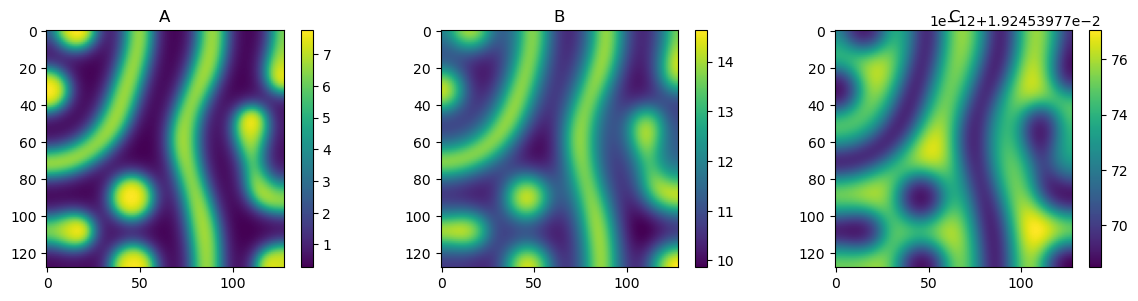

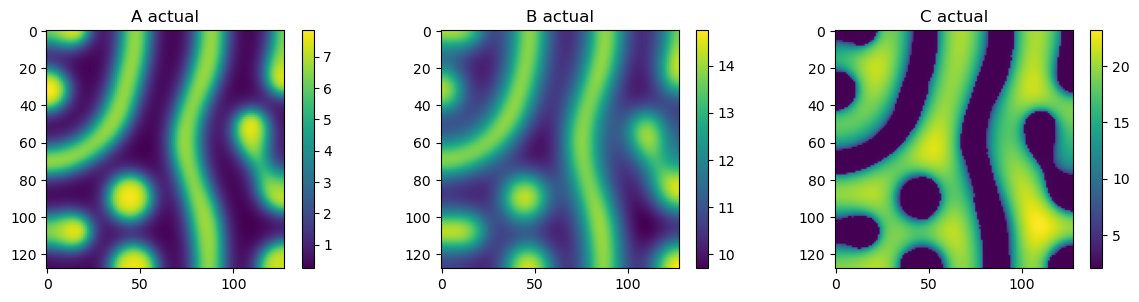

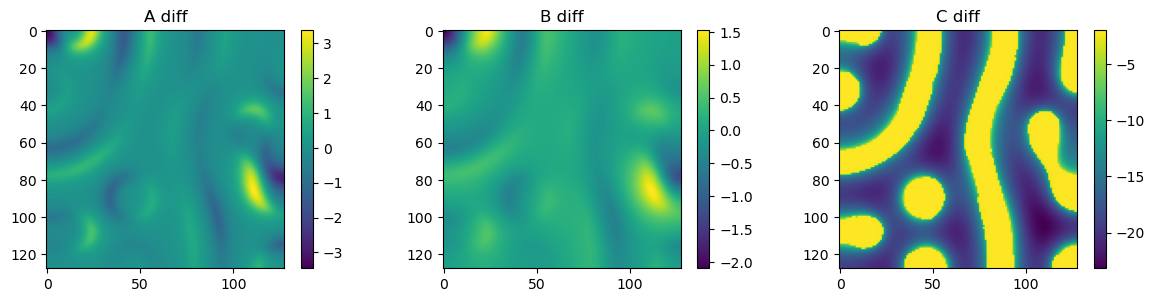

In [172]:
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")

sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import RD_2D_1st_Order, Neumann_Boundary_2D

D_A, D_B , n, mu_C= 0.01, 1.0, 4, params["mu_C"]
model_integrator = RD_2D_1st_Order(Ds=[D_A, D_B, 0], 
                        delta_t=100/5000, 
                        Lx=10, Ly=10, 
                        Ix=128, Jy=128,
                        boundary_condition=Neumann_Boundary_2D)
params2 = {}
for k,v in estimated_params.items():
    if not k.startswith("K"):
        params2[k] = v
    else:
        lower, upper = Ks_bounds[k]
        if v < lower:
            params2[k] = lower
        elif v > upper:
            params2[k] = upper
        else:
            params2[k] = v

kinetics = create_circuit_3954(n,params2["b_A"], params2["mu_A"], params2["V_A"], 
                                       params2["K_AA"], params2["K_AB"], params2["K_AC"],
                                       params2["b_B"], params2["mu_B"], params2["V_B"], 
                                       params2["K_BA"], params2["K_BC"],
                                       params2["b_C"], mu_C, params2["V_C"], 
                                       params2["K_CB"], params2["K_CC"])

(A_init, B_init, C_init) = (solution[0, 0, :, :].flatten(),
                            solution[0, 1, :, :].flatten(),
                            solution[0, 2, :, :].flatten())
solution_test = model_integrator.integrate([A_init, B_init, C_init],kinetics, 4*5000, record_steps=5000)

A_test = solution_test[-1,0, :].reshape((128,128))
B_test = solution_test[-1,1, :].reshape((128,128))
C_test = solution_test[-1,2, :].reshape((128,128))
plot_n_im([A_test,B_test,C_test], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([solution[105, 0, :, :],solution[105, 1, :, :],solution[105, 2, :, :]], 
           ["A actual","B actual","C actual"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([A_test-solution[105, 0, :, :],
           B_test-solution[105, 1, :, :],
           C_test-solution[105, 2, :, :]], 
           ["A diff","B diff","C diff"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 